# **Исследование надёжности заёмщиков — анализ банковских данных**

## Описание проекта
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

**Структура проекта**

- [Описание данных;](#review)
- [Загрузка данных;](#loading_data)
- [Предобработка данных;](#preprocessing)
- [Исследовательский анализ данных;](#analysis)
- [Выводы](#results)

<a id='review'></a>
## Описание данных
* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

**Импорт необходимых библиотек**

In [1]:
import pandas as pd
#import matplotlib as mpl
import matplotlib.pyplot as plt

<a id='loading_data'></a>
## Загрузка данных


In [2]:
data=pd.read_csv('data.csv')

In [3]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


* Данные содержат 21 525 строк и 12 столбцов
* В данных присутствуют пропуски 
* Тип данных в столбце `total_income`  -  `float64`. Заменим его на тип `int`

<a id='preprocessing'></a>
## Предобработка данных


### Удаление пропусков

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропуски обнаружены в столбцах: `days_employed` и `total_income`.
Так как сумма доходов зависит от типа занятости, заменим пропуски в столбце days_employed медианным значением по каждому типу в столбце `income_type`.

*Для заполнения пропусков выбираем медианное значение, так как оно делит выборку пополам так, что в одной половине значения меньше медианного, а в другой больше. Среднее значение может быть сильно завышено или занижено относительно медианного, так что при заполнении пропусков средним можно сильно исказить результаты дальнейшего исследования.*

In [6]:
income = data['income_type'].unique()

for inc in income:
    data.loc[(data['income_type']==inc) & (data['total_income'].isna()),'total_income'] =\
    data.loc[ data['income_type']==inc, 'total_income'].median()

Пропуски в столбце `days_employed` заполним медианными значениями для каждого типа занятости `income_type`.

In [7]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [8]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Пропуски были обнаружены в столбцах  `days_employed` (общий трудовой стаж в днях) и `total_income` (ежемесячный доход), причем в обоих этих колонках пропуски в одних и тех же строках, так что можно предположить, что это ошибка выгрузки данных.
Кроме технических ошибок причиной может быть человеческий фактор. Например, клиент не заполнил информацию о стаже и доходе из-за того, что не еще работал или работал не официально.

### Обработка аномальных значений

Чтобы выявить аномальные значения в датафрейме, посмотрим основные статистические характеристики данных по каждому столбцу и построим гистограммы. 

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000,2.152500e+04
mean,0.538908,63550.497071,43.293380,0.817236,0.972544,0.080883,1.652253e+05
std,1.381587,141150.420058,12.574584,0.548138,1.420324,0.272661,9.804367e+04
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2570.047544,33.000000,1.000000,0.000000,0.000000,1.077982e+05
50%,0.000000,-1355.683356,42.000000,1.000000,0.000000,0.000000,1.425944e+05
75%,1.000000,-316.240646,53.000000,1.000000,1.000000,0.000000,1.955499e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


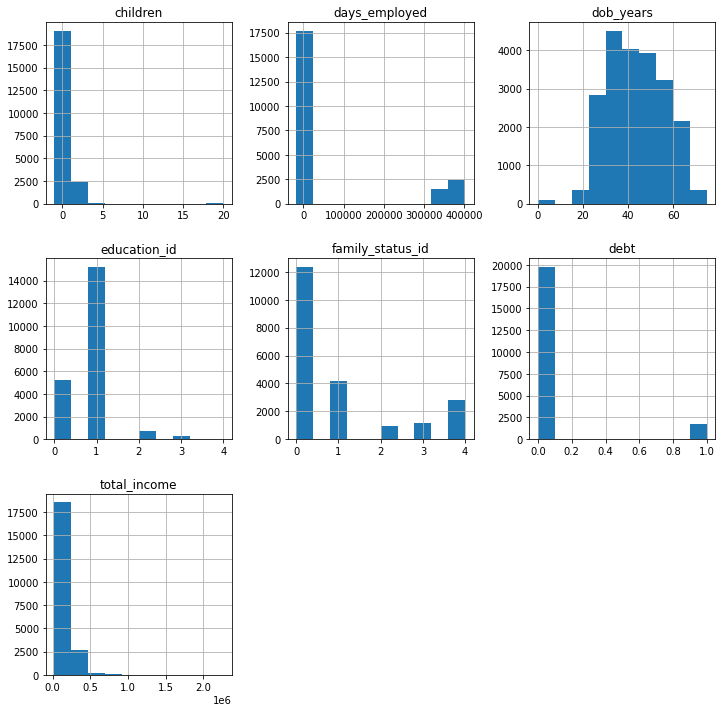

In [9]:
display(data.describe())
data.hist(figsize=(12,12))
plt.show()

* В столбце с количеством детей есть отрицательное значение и максимальное значение 20 детей, что  маловероятно. Удалим эти значения
* В столбце `days_employed` (общий трудовой стаж в днях) обнаружены отрицательные значения, так же максимальное значение 401755 дней (что равно примерно 1000 лет)
* Минимальный возраст клиентов 0 лет также выглядит подозрительно

In [10]:
# Удаление аномалий из столбца childrem
drop_index=data.loc[(data['children']==-1) | (data['children']==20)].index
data=data.drop(labels=drop_index, axis=0)
display(data['children'].unique())


array([1, 0, 3, 2, 4, 5], dtype=int64)

In [11]:
# Заменим все отрицательные значения В столбце days_employed положительными.
data['days_employed']=data['days_employed'].abs()
# для каждого типа занятости выведем медианное значение трудового стажа `days_employed` в днях.
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

Аномально высокие значения обнаружены у пенсионеров и безработных. Судя по гистограммам построенных выше таких значений очень мало, но удалять их из датасета не будем, так как зависимость между рабочим стажем и возвратом кредита в срок в нашем исследовании не учитывается. 


Посмотрим уникальные значения возрастов пользователей моложе 18 лет. 

In [12]:
data.query('dob_years < 18')['dob_years'].unique()

array([0], dtype=int64)

Те самые значения '0'. Видимо эти пользователи просто не заполнили графу с возрастом. Оставим эти строки, так как данный столбец не учитывается в нашем исследовании.

### Изменение типов данных

Заменим вещественный тип данных в столбце `total_income` на целочисленный с помощью метода `astype()`.

In [13]:
data['total_income']=data['total_income'].astype('int')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21402 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21402 non-null  int64  
 1   days_employed     21402 non-null  float64
 2   dob_years         21402 non-null  int64  
 3   education         21402 non-null  object 
 4   education_id      21402 non-null  int64  
 5   family_status     21402 non-null  object 
 6   family_status_id  21402 non-null  int64  
 7   gender            21402 non-null  object 
 8   income_type       21402 non-null  object 
 9   debt              21402 non-null  int64  
 10  total_income      21402 non-null  int32  
 11  purpose           21402 non-null  object 
dtypes: float64(1), int32(1), int64(5), object(5)
memory usage: 2.0+ MB


### Обработка дубликатов

**Обработка явных дубликатов**

In [15]:
display(data.duplicated().sum())
data=data.drop_duplicates()
display(data.duplicated().sum())

54

0

**Обработка неявных дубликатов**

Посмотрим уникальные значения в столбцах со строковыми значениями. 

In [16]:
display(data['education'].unique())
display(data['family_status'].unique())
display(data['gender'].unique())
display(data['income_type'].unique())
display(data['purpose'].unique())

array(['высшее', 'среднее', 'Среднее', 'СРЕДНЕЕ', 'ВЫСШЕЕ',
       'неоконченное высшее', 'начальное', 'Высшее',
       'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'Неоконченное высшее', 'НАЧАЛЬНОЕ',
       'Начальное', 'Ученая степень', 'УЧЕНАЯ СТЕПЕНЬ', 'ученая степень'],
      dtype=object)

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

array(['F', 'M', 'XNA'], dtype=object)

array(['сотрудник', 'пенсионер', 'компаньон', 'госслужащий',
       'безработный', 'предприниматель', 'студент', 'в декрете'],
      dtype=object)

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

* В столбце `education` есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведем их к нижнему регистру.
* В столбце `purpose` очень много наименований целей кредита. Объединим их в категории:
    - `'операции с автомобилем'`,
    - `'операции с недвижимостью'`,
    - `'проведение свадьбы'`,
    - `'получение образования'`

In [17]:
data['education']=data['education'].str.lower()

In [18]:
# создадим функцию categorize_purpose()
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

data['purpose_category'] = data['purpose'].apply(categorize_purpose)

display(data['purpose_category'].unique())

array(['операции с недвижимостью', 'операции с автомобилем',
       'получение образования', 'проведение свадьбы'], dtype=object)

### Категоризация данных

Разделим пользователей на категории относительно ежемесячного дохода:
- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [19]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass
data['total_income_category'] = data['total_income'].apply(categorize_income)
data['total_income_category'].unique()

array(['B', 'C', 'D', 'E', 'A'], dtype=object)

<a id='analysis'></a>
## Исследовательский анализ данных 


### Есть ли зависимость между количеством детей и возвратом кредита в срок?

In [20]:
#сгруппируем таблицу по столбцу 'children' и посчитаем количество заемщиков в каждой категории
children_group=data.groupby('children')['debt'].count()
children_group=pd.DataFrame(data=children_group)  

#посчитаем количество заемщиков имеющих задолженности и добавим их к таблице children_group
children_pivot=data.pivot_table(index=['children'], columns=data[data['debt']==1]['debt'], values='days_employed',aggfunc='count')
children_pivot=children_group.merge(children_pivot, on='children', how='left')

#Посчитаем долю просрочек в %, добавим столбец к таблице children_pivot
children_arrears=children_pivot[1]/children_pivot['debt']*100
children_arrears=pd.DataFrame(data=children_arrears)
children_pivot=children_pivot.merge(children_arrears, on='children', how='left')
children_pivot=children_pivot.rename(columns={'debt':'number of borrowers',1:'debtors' , 0:'share of arrears (%)'})
children_pivot.sort_values(by='share of arrears (%)',ascending=False)

,number of borrowers,debtors,share of arrears (%)
children,,,
4,41,4.0,9.756098
2,2052,194.0,9.454191
1,4809,444.0,9.232689
3,330,27.0,8.181818
0,14107,1063.0,7.535266
5,9,NaN,NaN


**Вывод:** 
- Клиентов с 3,4 и 5 детьми среди всех заемщиков менее 5%, при этом все клиенты с 5 детьми вообще не имеют задолженностей, поэтому при оценке зависимостей мы не можем учитывать эти категории; 
- Наибольший процент должников отмечается в категориях клиентов с 2 или 1 ребенком (более 9%);
- Меньше всего должников среди клиентов без детей (7,5%);
   
*Клиенты с 3 и более детьми реже берут кредиты.*

*При сравнении категорий клиентов без детей, с 1 и с 2 детьми, видно, что доля просрочки увеличивается с увеличением количества детей, так наиболее надежной категорией будут клиенты без детей.*

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [21]:
#сгруппируем таблицу по столбцу 'family_status' и посчитаем количество заемщиков в каждой категории
family_group=data.groupby('family_status')['debt'].count()
family_group=pd.DataFrame(data=family_group)

#посчитаем количество заемщиков имеющих задолжености и добавим их к таблице family_group
family_pivot=data.pivot_table(index=['family_status'], columns=data[data['debt']==1]['debt'], values='days_employed',aggfunc='count')
family_pivot=family_group.merge(family_pivot, on='family_status', how='left')

#Посчитаем долю просрочек в %, добавим столбец к таблице family_pivot
family_arrears=family_pivot[1]/family_pivot['debt']*100
family_arrears=pd.DataFrame(data=family_arrears)
family_pivot=family_pivot.merge(family_arrears, on='family_status', how='left')
family_pivot=family_pivot.rename(columns={'debt':'number of borrowers',1:'debtors' , 0:'share of arrears (%)'})
family_pivot.sort_values(by='share of arrears (%)',ascending=False)


,number of borrowers,debtors,share of arrears (%)
family_status,,,
Не женат / не замужем,2796,273,9.763948
гражданский брак,4146,385,9.286059
женат / замужем,12266,927,7.557476
в разводе,1189,84,7.064760
вдовец / вдова,951,63,6.624606


**Вывод:** 
- Наибольшая доля просрочек отмечается в категориях не женатых/не замужних и состоящих в гражданском браке клиентов;
- Женатые и замужние клиенты отдают кредиты лучше;
- Можно предположить, что клиенты в разводе и вдовцы/вдовы являются наиболее надежной категорией, однако их количество среди всех заемщиков менее 5%, так что выборку можно считать не репрезентативной  

*Если не учитывать при сравнении категории разведенных и вдовцов, видно, что доля просрочек уменьшается при вступлении в брак*

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [22]:
#сгруппируем таблицу по столбцу 'total_income_category' и посчитаем количество заемщиков в каждой категории
income_group=data.groupby('total_income_category')['debt'].count()
income_group=pd.DataFrame(data=income_group)

#посчитаем количество заемщиков имеющих задолжености и добавим их к таблице income_group
income_pivot=data.pivot_table(index=['total_income_category'], columns=data[data['debt']==1]['debt'], values='days_employed',aggfunc='count')
income_pivot=income_group.merge(income_pivot, on='total_income_category', how='left')

#Посчитаем долю просрочек в %, добавим столбец к таблице income_pivot
income_arrears=income_pivot[1]/income_pivot['debt']*100
income_arrears=pd.DataFrame(data=income_arrears)
income_pivot=income_pivot.merge(income_arrears, on='total_income_category', how='left')
income_pivot=income_pivot.rename(columns={'debt':'number of borrowers',1:'debtors' , 0:'share of arrears (%)'})
income_pivot.sort_values(by='share of arrears (%)',ascending=False)

,number of borrowers,debtors,share of arrears (%)
total_income_category,,,
E,22,2,9.090909
C,15938,1353,8.489145
A,25,2,8.000000
B,5014,354,7.060231
D,349,21,6.017192


**Вывод:** 
- Преобладающее количество заемщиков имеют доходы от 50001 до 1000000 руб, выборки по остальным категориям можно считать не репрезентативными;
- Клиенты с доходом 200001–1000000 руб. отдают кредиты лучше, клиентов с доходом 50001–200000 руб.;

*При сравнении репрезентативных выборок видна прямая зависимость между уровнем дохода и частотой погашения долга-чем выше доход, тем меньше доля просрочек.*

### Как разные цели кредита влияют на его возврат в срок?

In [23]:
#сгруппируем таблицу по столбцу 'purpose_category' и посчитаем количество заемщиков в каждой категории
purpose_group=data.groupby('purpose_category')['debt'].count()
purpose_group=pd.DataFrame(data=purpose_group)

#посчитаем количество заемщиков имеющих задолжености и добавим их к таблице purpose_group
purpose_pivot=data.pivot_table(index=['purpose_category'], columns=data[data['debt']==1]['debt'], values='days_employed',aggfunc='count')
purpose_pivot=purpose_group.merge(purpose_pivot, on='purpose_category', how='left')

#Посчитаем долю просрочек в %, добавим столбец к таблице purpose_pivot
purpose_arrears=purpose_pivot[1]/purpose_pivot['debt']*100
purpose_arrears=pd.DataFrame(data=purpose_arrears)
purpose_pivot=purpose_pivot.merge(purpose_arrears, on='purpose_category', how='left')
purpose_pivot=purpose_pivot.rename(columns={'debt':'number of borrowers',1:'debtors' , 0:'share of arrears (%)'})
purpose_pivot.sort_values(by='share of arrears (%)',ascending=False)

,number of borrowers,debtors,share of arrears (%)
purpose_category,,,
операции с автомобилем,4281,400,9.343611
получение образования,3989,369,9.250439
проведение свадьбы,2324,183,7.874355
операции с недвижимостью,10754,780,7.253115


**Вывод:** 
- Наибольшая доля просрочек отмечается в категориях операции с автомобилем и получение образования;
- Самой надежной категорией клиентов, согласно данным, являются клиенты, взявшие кредит на проведение свадьбы и операции с недвижимостью.

*Наибольшая доля должников среди клиентов, взявших кредит на операции с автомобилем и получение образования может быть связано с другими факторами, например, семьи с детьми могут брать кредиты на автомобиль и образование чаще.* 

<a id='results'></a>
## Выводы


В качестве исходных данных была использована статистика о платёжеспособности клиентов, предоставленная кредитным отделом банка.

**На этапе предобработки в данных были выявлены следующие проблемы:**
- в столбцах days_employed (общий трудовой стаж в днях) и total_income (ежемесячный доход) были обнаружены пропуски. Данные о доходе клиента важны для исследования, поэтому пропуски были заполнены медианным доходом, рассчитанным для каждого типа занятости. 
- В столбцах days_employed и children были обнаружены аномальные значения. 
- Так же были обнаружены неявные дубликаты в столбце education - одни и те же значения, но записанные в разных регистрах.


**При анализе данных были выявлено, что зависимость между рассматриваемыми категориями и возвратом кредита в срок есть.** 

Были отмечены наименее надежные категории клиентов это: 
- клиенты с 1 или 2 детьми, 
- не женатые клиенты, 
- клиенты с низким доходом. 
- Хуже всего выплачивают кредиты на операции с автомобилем и получение образования.

Стоит отметить, что доли просрочек по каждой из категорий не сильно отличаются друг от друга (на 2-3 ед.). 

Из-за не репрезентативности выборок по некоторым категориям клиентов, возможно эти категории следует исследовать отдельно и более детально по большему количеству признаков (возраст, уровень образования, тип занятости и т.д.).

**Рекомендации, по улучшению сбора данных и настройке системы скоринга:**
- Рекомендовано отрегулировать систему валидации при выгрузке данных во избежание возникновения дубликатов. 
- Сделать все поля анкеты обязательными к заполнению клиентом, чтобы не допустить возникновения пропусков 
- Установить лимит для вводимых значений (например, чтобы пользователь не смог записать в анкете, что у него стаж более 1000 лет или -1 ребенок)
- Сделать автоматическую замену регистра, при заполнении полей со строковыми значениями, чтобы в анкете не было неявных дубликатов.